NOTE: I did some basic logistic regression here. This ended up not showing up in my final project but if you do read this, hi.

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler

from functions import *

sns.set_style("white")
plt.rcParams['figure.dpi'] = 75

In [28]:
treatment_fimo = pd.read_csv('./TFBS Regression Modeling/trmt_fimo/fimo.tsv', header=0, sep='\t', comment='#')
control_fimo = pd.read_csv('./TFBS Regression Modeling/ctrl_fimo/fimo.tsv', header=0, sep='\t', comment='#')


treatment_wide = get_wide_matrix(treatment_fimo)
control_wide = get_wide_matrix(control_fimo)

In [29]:
treatment_label = [1 for i in range(treatment_wide.shape[0])]
control_label = [0 for i in range(control_wide.shape[0])]

treatment_wide['label'] = treatment_label
control_wide['label'] = control_label
# This took 0.0s don't even dare complain that I should've used numpy for this. List comprehension (fancy looping) is fast enough

In [30]:
print(f"Treamtent shape: {treatment_wide.shape}\nControl shape: {control_wide.shape}")
combined_wide = pd.concat([treatment_wide, control_wide], axis=0)
print(f"Combined shape: {combined_wide.shape}")
combined_wide.info()

Treamtent shape: (2902, 38)
Control shape: (2863, 38)
Combined shape: (5765, 38)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5765 entries, 0 to 2862
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sequence_name  5765 non-null   object
 1   STREME-1       5765 non-null   int64 
 2   STREME-2       5765 non-null   int64 
 3   STREME-3       5765 non-null   int64 
 4   STREME-4       5765 non-null   int64 
 5   STREME-5       5765 non-null   int64 
 6   STREME-6       5765 non-null   int64 
 7   STREME-7       5765 non-null   int64 
 8   STREME-9       5765 non-null   int64 
 9   STREME-10      5765 non-null   int64 
 10  STREME-11      5765 non-null   int64 
 11  STREME-12      5765 non-null   int64 
 12  STREME-13      5765 non-null   int64 
 13  STREME-14      5765 non-null   int64 
 14  STREME-15      5765 non-null   int64 
 15  STREME-16      5765 non-null   int64 
 16  STREME-17      5765 non-null   in

Shape looks good, and matrices are stacked. Let's regress (after looking at class imbalance lol)

Text(0.5, 1.0, 'Control (blue) and treatment (orange) counts')

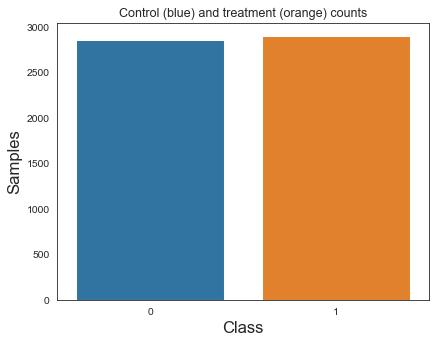

In [33]:
sns.countplot(data=combined_wide, x="label")
plt.xlabel("Class", fontsize=16)
plt.ylabel("Samples", fontsize=16)
plt.title("Control (blue) and treatment (orange) counts")

Perfectly (not really) balanced, as all thing should be. Let us actually do the machine learning now.

In [43]:
model_data = combined_wide.iloc[:,1:]

#rename so patsy doesn't complain... again
rename_X = {}
for column in model_data.columns:
    rename_X[column] = "".join(column.split('-'))

model_data = model_data.rename(columns=rename_X)

model_string = "label ~ "
for col in model_data.columns:
    if col != "label":
        model_string += f"{col} + "

model_string = model_string[:-2]

y, X = dmatrices(model_string, data=model_data, return_type="dataframe")


In [44]:
model = sm.Logit(endog=y, exog=X)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.539631
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                 5765
Model:                          Logit   Df Residuals:                     5728
Method:                           MLE   Df Model:                           36
Date:                Wed, 08 Feb 2023   Pseudo R-squ.:                  0.2215
Time:                        13:16:50   Log-Likelihood:                -3111.0
converged:                       True   LL-Null:                       -3995.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3444      0.060    -22.427      0.000      -1.462      -1.227
STREME1        0.6274      0.

Text(0.5, 1.0, 'Confidence that is class 1 (treatment)')

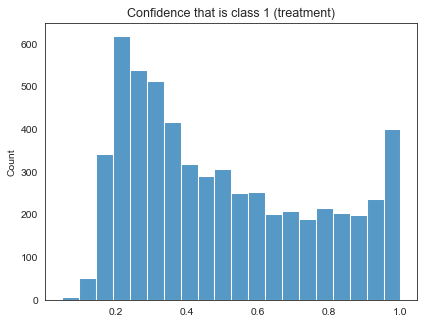

In [50]:
pred_y = results.predict(X)
sns.histplot(x=pred_y)
plt.title("Confidence that is class 1 (treatment)")

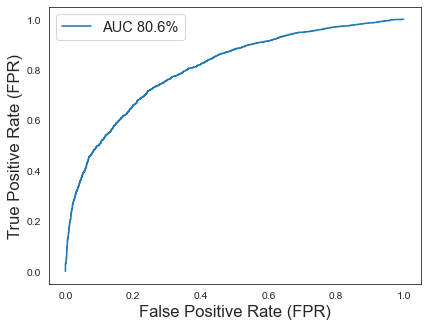

In [52]:
roc_auc = roc_auc_score(y, pred_y)
fpr, tpr, _ = roc_curve(y, pred_y)
plt.plot(fpr, tpr, label="AUC {:.1%}".format(roc_auc))
plt.xlabel("False Positive Rate (FPR)", fontsize=16)
plt.ylabel("True Positive Rate (FPR)", fontsize=16)
plt.legend(fontsize=14)

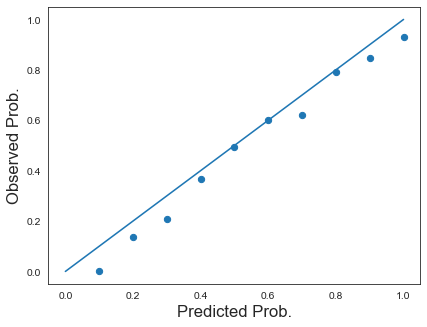

In [54]:
bins = np.linspace(0, 1, num=11, endpoint=True)
bin_pos, _ = np.histogram(pred_y[y["label"] == 1], bins=bins)
bin_total, _ = np.histogram(pred_y, bins=bins)

bin_pred = bin_pos / bin_total

plt.scatter(bins[1:], bin_pred)
plt.plot([0, 1], [0, 1])
plt.xlabel("Predicted Prob.", fontsize=16)
_ = plt.ylabel("Observed Prob.", fontsize=16)